# Univariate

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller,
                              seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [9]:
def split_data(data, test_split):
    l=len(data)
    t_idx =round(l*(1-test_split))
    train, test= data[:t_idx],data[t_idx:]
    print(f'train:{len(train)}, test:{len(test)}')
    return train,test

In [11]:
def check_stationarity(df):
    results =adfuller(df)[1:3]
    s= 'Non-staionary'
    if results[0]<0.05:
        s='Staionary'
    print(f"'{s}\t p-val :{resultslts[0]}\t lags:{results[1]}")
    return (s, results[0])

In [13]:
def get_best_model(score, c='AIC'):
    inital_score=score[0][c]
    best_model=0
    for k,v in score.items():
        if v[c]<initial_score:
            initial_score=v[c]
            best_model=k
    print(f'Best model:{best_model} with lowest {c} score:{inital_score}')
    return score[best_model]['model']

In [14]:
def plot_forecast(model,start,train,test):
    forecast =pd.DataFrame(model.forecast(test.shape[0]),
                          index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train','orig_test','forecast'])
    plt.show()

In [15]:
def combinator(items):
    combo=[i for i in product(*items)]
    return combo

In [5]:
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')
life = pd.read_csv(life_file,
                   index_col='year',
                   parse_dates=True,
                  skipfooter=1)
milk = pd.read_csv(milk_file,
                   index_col='month',
                   parse_dates=True)

<AxesSubplot: title={'center': 'Monthly Milk Production'}, xlabel='month'>

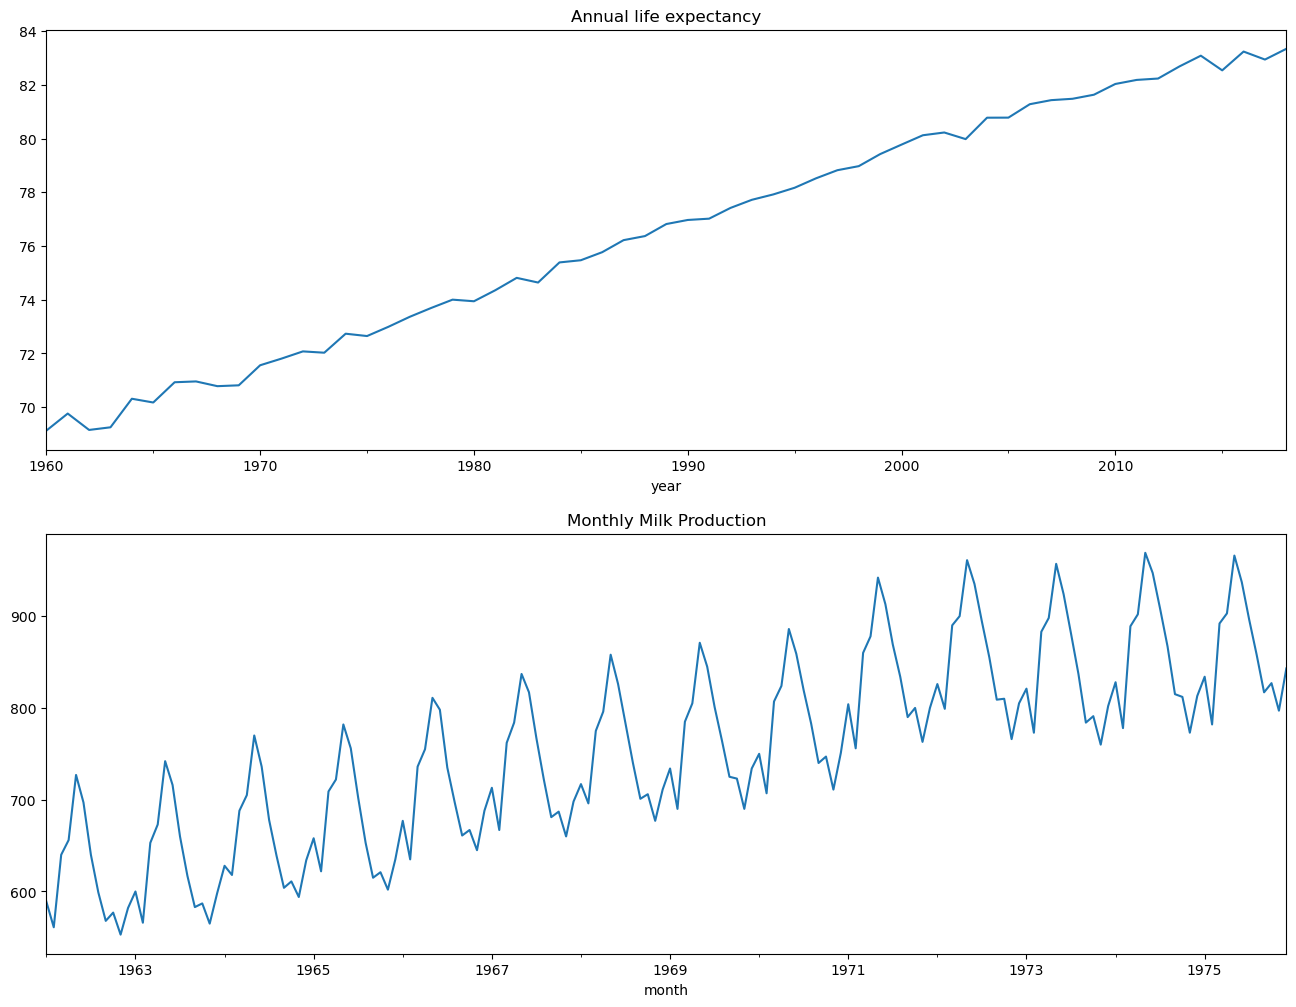

In [6]:
fig, ax =plt.subplots(2,1,figsize=(16,12))
life.plot(title='Annual life expectancy',
         legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production',
         legend=False,ax=ax[1])

In [10]:
test_split=0.15
milk_train, milk_test =split_data(milk, test_split)
life_train, life_test= split_data(life, test_split)

train:143, test:25
train:50, test:9


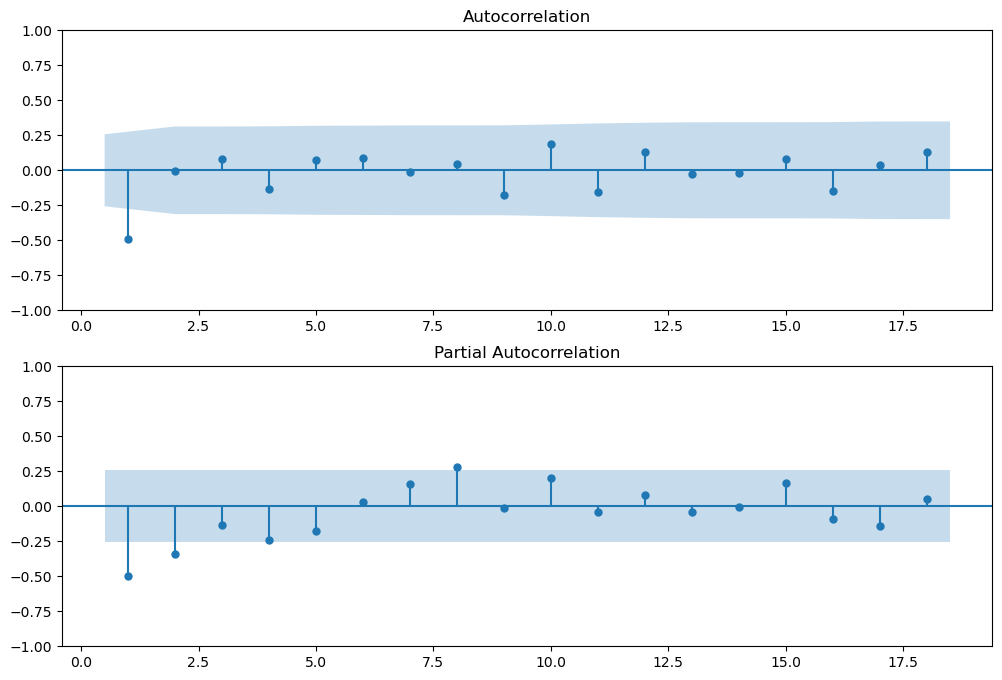

In [16]:
life_diff=life.diff().dropna()
fig, ax =plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff,zero=False,ax=ax[0])
plot_pacf(life_diff,zero=False,ax=ax[1])
plt.show()